In [1]:
# copied directly from https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

print(f"Number of letters is {n_letters}")

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

Number of letters is 59
# categories: 18 ['Polish', 'English', 'Korean', 'Portuguese', 'Italian', 'Scottish', 'French', 'Czech', 'Dutch', 'Japanese', 'Russian', 'Arabic', 'Chinese', 'Vietnamese', 'Greek', 'German', 'Spanish', 'Irish']
O'Neal


In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        # 1 x 57 concat 1 x 59 concat 1 x 128 = 1 x 205
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [4]:
# One-hot vector for category
def categoryTensor(category):
    """
    Converts a category (string) into a one-hot encoded tensor.

    Args:
        category (str): The category name to be converted into a tensor.

    Returns:
        torch.Tensor: A tensor of size (1 x n_categories) with a one-hot encoding representing the category.
    
    Example:
        >>> all_categories = ['cat1', 'cat2', 'cat3']
        >>> n_categories = len(all_categories)
        >>> categoryTensor('cat2')
        tensor([[0., 1., 0.]])
    """
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    '''
    Converts a line (string) into a tensor of one-hot vectors representing each character.
    
    Input: 
        line (str): A string representing a name.
        
    Output: 
        tensor (torch.Tensor): A tensor of size (line length x 1 x n_letters) representing the line.
    '''
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    '''
    Converts a line (string) into a tensor of letter indices, excluding the first character and adding an end-of-sequence (EOS) marker.
    
    Input:
        line (str): A string representing a name.
        
    Output:
        torch.LongTensor: A tensor of letter indices (1 x line length), with the first character removed and an EOS marker appended.
    
    Example:
        Assuming:
        all_letters = 'abcdefghijklmnopqrstuvwxyz'
        n_letters = 27  # 26 letters + EOS
        
        >>> line = "hello"
        >>> result = targetTensor(line)
        >>> print(result)
        tensor([ 4,  11,  11,  14, 26])
        
        This represents:
        - 4  (index of 'e' in all_letters)
        - 11 (index of 'l' in all_letters)
        - 11 (index of 'l' in all_letters)
        - 14 (index of 'o' in all_letters)
        - 26 (EOS marker, which is n_letters - 1)
    '''
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [5]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [6]:
criterion = nn.NLLLoss()

learning_rate = 0.0005


In [7]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
rnn = RNN(n_letters, 128, n_letters)

def train(category_tensor, input_line_tensor, target_line_tensor):
    # becomes (line length x 1)
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        # output is a probability distribution of size [vocab size]
        print(f"predicted: {output}, expected: {target_line_tensor[i]}")
        l = criterion(output, target_line_tensor[i])
        #print(f"current loss is {l}")
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

predicted: tensor([[-4.1339, -4.0625, -4.0484, -4.1399, -4.0825, -4.0770, -4.0871, -4.1129,
         -4.0671, -4.0521, -4.0511, -4.0651, -4.0676, -4.0651, -4.0784, -4.1321,
         -4.1205, -4.1408, -4.1051, -4.1890, -4.1975, -4.0651, -4.0314, -4.0140,
         -4.0283, -4.0166, -4.0225, -4.0757, -4.0762, -4.0163, -4.0652, -4.1817,
         -4.0186, -4.0696, -4.1488, -4.1765, -4.1074, -4.0513, -3.9678, -4.0975,
         -4.0801, -4.1460, -4.1134, -4.1119, -4.0651, -4.1239, -4.0651, -4.0240,
         -4.0272, -4.0864, -4.0205, -4.0963, -4.1357, -4.0651, -4.1414, -4.0059,
         -3.9016, -4.0210, -4.1271]], grad_fn=<LogSoftmaxBackward0>), expected: tensor([0])
predicted: tensor([[-4.1215, -4.1206, -4.0525, -4.1485, -4.1248, -4.0516, -4.0861, -4.0862,
         -4.0567, -4.0346, -4.0349, -4.0620, -4.1124, -4.0986, -4.1071, -4.0620,
         -4.0855, -4.0686, -4.1120, -4.1771, -4.1158, -4.0758, -4.0161, -3.9770,
         -4.0487, -4.0057, -4.0774, -4.1089, -4.0600, -4.0576, -4.0918, -4.1

KeyboardInterrupt: 

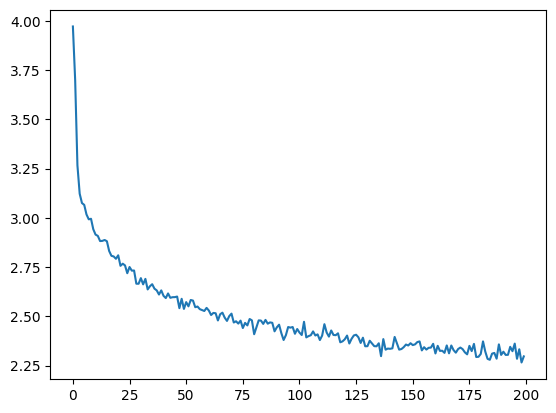

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            #print(output)
            topv, topi = output.topk(1)
            #print(f"topv: {topv}, topi: {topi}")
            topi = topi[0][0]
            # if the index is EOS index
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            # convert next letter into tensor
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
    print("-" * 50)


samples("Korean")


Ang
Ban
Cou
--------------------------------------------------


study about  NLLoss 

In [ ]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(1, 5, requires_grad=True)
ran_over = m(input)
# each element in target has to have 0 <= value < C
target = torch.tensor([4])
output = loss(ran_over, target)
output.backward()

print(input)
print(ran_over)
print(target)
print(output)

tensor([[-0.3466, -2.4400, -2.0722, -0.6038,  0.3092]], requires_grad=True)
tensor([[-1.3866, -3.4800, -3.1122, -1.6438, -0.7308]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([4])
tensor(0.7308, grad_fn=<NllLossBackward0>)
